In [ ]:
!lscpu |grep 'Model name'
!nvidia-smi
!pip install ax-platform

Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
Sat Mar 18 21:25:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    22W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [ ]:
import pandas as pd
from ax import *
import torch

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

from ax.service.utils.report_utils import exp_to_df
from ax.runners.synthetic import SyntheticRunner
from ax.metrics.noisy_function import GenericNoisyFunctionMetric

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from botorch.test_functions.multi_objective import ZDT1

In [ ]:
tkwargs = {
    "dtype": torch.double, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [ ]:
dim = 30
problem = ZDT1(num_objectives=2, dim=dim, negate=False).to(**tkwargs)

param_names = [f"x{i}" for i in range(dim)]

def f1(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names] # Obtiene los parámetros a evaluar
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[0]) # Evalúa los parámetros en el primer objetivo
    
def f2(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names]
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[1]) # Evalúa los parámetros en el segundo objetivo

metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)

In [ ]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name=param_name, lower=0, upper=1, parameter_type=ParameterType.FLOAT)
        for param_name in param_names
        ]
)

mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, problem.ref_point)
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [ ]:
N_INIT = 2 * (dim + 1)
N_BATCH = 5
BATCH_SIZE = 1

def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

In [ ]:
import time

executions = 10
execution_times = []
all_df = []
all_outcomes = []

for exec in range(executions):
  start_time = time.time()

  experiment = build_experiment()
  data = initialize_experiment(experiment)

  hv_list = []
  model = None
  for i in range(N_BATCH):   
      model = Models.FULLYBAYESIANMOO(
          experiment=experiment, 
          data=data,
          num_samples=16,
          warmup_steps=32,
          torch_device=tkwargs["device"],
      )
      generator_run = model.gen(BATCH_SIZE)
      trial = experiment.new_trial(generator_run=generator_run)
      trial.run()
      data = Data.from_multiple_data([data, trial.fetch_data()])
      
      exp_df = exp_to_df(experiment)
      outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
      try:
          hv = observed_hypervolume(modelbridge=model)
      except:
          hv = 0
          print("Failed to compute hv")
      hv_list.append(hv)
      print(f"Execution: {exec + 1}, Iteration: {i + 1}, HV: {hv}")

  execution_times.append(time.time() - start_time)

  all_df.append(exp_to_df(experiment).sort_values(by=["trial_index"]))
  all_outcomes.append(np.array(exp_to_df(experiment)[['a', 'b']], dtype=np.double))

Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=5.67e-01, acc. prob=0.616]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 1, HV: 90.47335865875219


Sample: 100%|██████████| 48/48 [00:21,  2.19it/s, step size=6.05e-01, acc. prob=0.707]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 2, HV: 117.52691961955897


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=5.68e-01, acc. prob=0.652]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 3, HV: 120.0


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=8.25e-01, acc. prob=0.213]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 4, HV: 120.0


Sample: 100%|██████████| 48/48 [00:22,  2.15it/s, step size=3.48e-01, acc. prob=0.910]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 5, HV: 120.0


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=3.98e-01, acc. prob=0.851]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 1, HV: 90.80939343328365


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=6.16e-01, acc. prob=0.501]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 2, HV: 117.4965632624067


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=4.43e-01, acc. prob=0.798]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 3, HV: 120.0


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=5.02e-01, acc. prob=0.720]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 4, HV: 120.0


Sample: 100%|██████████| 48/48 [00:22,  2.17it/s, step size=3.87e-01, acc. prob=0.908]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 5, HV: 120.0


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=3.05e-01, acc. prob=0.930]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 1, HV: 91.23646242858749


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=4.09e-01, acc. prob=0.842]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 2, HV: 117.59609840136956


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=4.32e-01, acc. prob=0.850]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 3, HV: 120.0


Sample: 100%|██████████| 48/48 [00:17,  2.78it/s, step size=7.03e-01, acc. prob=0.032]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 4, HV: 120.0


Sample: 100%|██████████| 48/48 [00:21,  2.22it/s, step size=6.17e-01, acc. prob=0.484]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 5, HV: 120.0


Sample: 100%|██████████| 48/48 [00:18,  2.57it/s, step size=4.40e-01, acc. prob=0.874]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 1, HV: 92.21003202109898


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=4.56e-01, acc. prob=0.885]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 2, HV: 117.42148529546002


Sample: 100%|██████████| 48/48 [00:16,  2.93it/s, step size=7.10e-01, acc. prob=0.131]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 3, HV: 119.76461413353394


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=3.43e-01, acc. prob=0.904]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 4, HV: 119.76461413353394


Sample: 100%|██████████| 48/48 [00:12,  3.76it/s, step size=5.97e-01, acc. prob=0.063]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 5, HV: 119.76461413353394


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=3.41e-01, acc. prob=0.898]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 1, HV: 92.21903040878124


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=4.69e-01, acc. prob=0.757]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 2, HV: 117.59012888846596


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.71e-01, acc. prob=0.886]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 3, HV: 119.98369057877525


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=4.63e-01, acc. prob=0.842]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 4, HV: 119.98369057877525


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=3.61e-01, acc. prob=0.697]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 5, HV: 119.98369057877525


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=4.55e-01, acc. prob=0.807]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 1, HV: 92.80737766374621


Sample: 100%|██████████| 48/48 [00:25,  1.89it/s, step size=2.50e-01, acc. prob=0.855]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 2, HV: 117.58501584725668


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=2.85e-01, acc. prob=0.950]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 3, HV: 119.94531985361422


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=5.50e-01, acc. prob=0.527]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 4, HV: 119.94531985361422


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.21e-01, acc. prob=0.910]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 5, HV: 119.94531985361422


Sample: 100%|██████████| 48/48 [00:09,  4.96it/s, step size=5.24e-01, acc. prob=0.043]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 1, HV: 93.68402243525048


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=6.04e-01, acc. prob=0.399]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 2, HV: 117.28607655017014


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=5.75e-01, acc. prob=0.669]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 3, HV: 119.7405136752232


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=6.28e-01, acc. prob=0.358]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 4, HV: 119.7405136752232


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=4.00e-01, acc. prob=0.876]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 5, HV: 119.7405136752232


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=3.68e-01, acc. prob=0.928]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 1, HV: 91.15439504039746


Sample: 100%|██████████| 48/48 [00:18,  2.55it/s, step size=6.42e-01, acc. prob=0.179]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 2, HV: 117.60369030943602


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=4.80e-01, acc. prob=0.731]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 3, HV: 119.90830169287648


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=2.96e-01, acc. prob=0.895]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 4, HV: 120.27348338904538


Sample: 100%|██████████| 48/48 [00:14,  3.24it/s, step size=8.77e-01, acc. prob=0.026]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 5, HV: 120.27348338904538


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=5.30e-01, acc. prob=0.803]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 1, HV: 91.5494173484631


Sample: 100%|██████████| 48/48 [00:20,  2.37it/s, step size=1.11e-01, acc. prob=0.782]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 2, HV: 117.53554059372537


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=3.47e-01, acc. prob=0.939]
/usr/local/lib/python3.9/dist-packages/ax/service/utils/report_utils.py:746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results[FEASIBLE_COL_NAME] = _is_row_feasible(
/usr/local/lib/python3.9/dist-packages/ax/service/utils/report_utils.py:631: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results[results_key_col] = key_vals
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI

Execution: 9, Iteration: 3, HV: 120.0


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=6.09e-01, acc. prob=0.388]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 4, HV: 120.0


Sample: 100%|██████████| 48/48 [00:19,  2.49it/s, step size=3.53e-01, acc. prob=0.914]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 5, HV: 120.0


Sample: 100%|██████████| 48/48 [00:09,  4.99it/s, step size=6.05e-01, acc. prob=0.162]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 1, HV: 90.8726464025678


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=2.18e-01, acc. prob=0.945]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 2, HV: 117.33081309597141


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=5.03e-01, acc. prob=0.851]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 3, HV: 119.54469630685558


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=5.00e-01, acc. prob=0.776]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 4, HV: 119.54469630685558


Sample: 100%|██████████| 48/48 [00:22,  2.13it/s, step size=3.76e-01, acc. prob=0.825]


Execution: 10, Iteration: 5, HV: 119.54469630685558


/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


<ipython-input-11-7f1c810ba2de>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


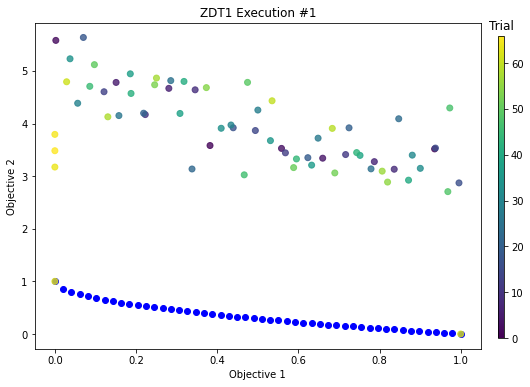

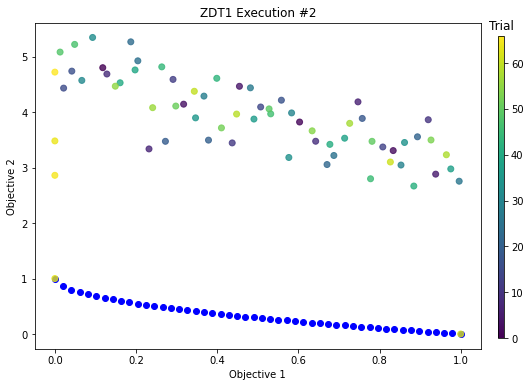

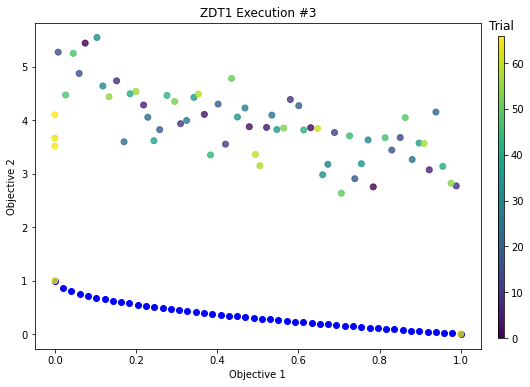

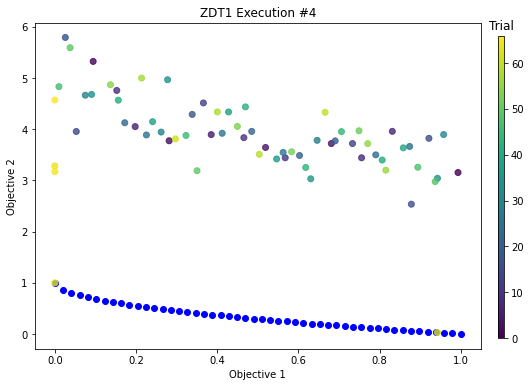

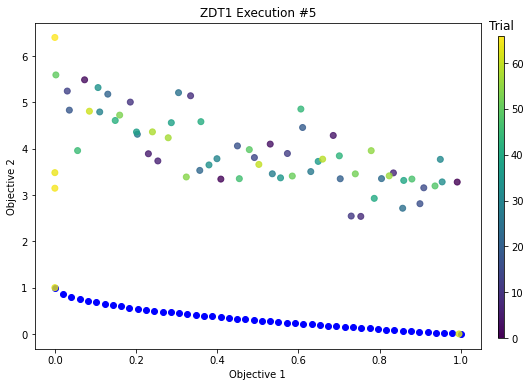

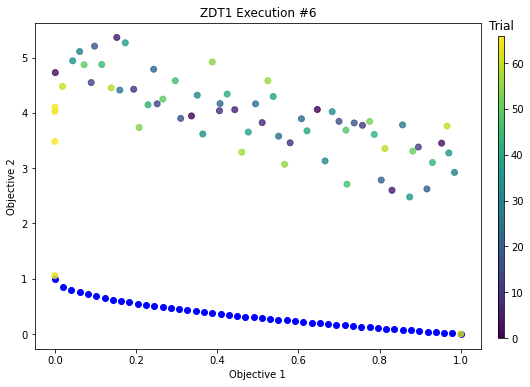

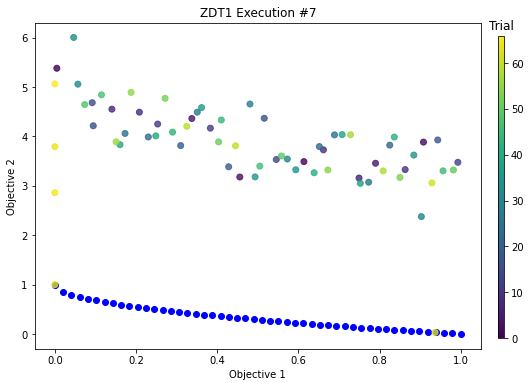

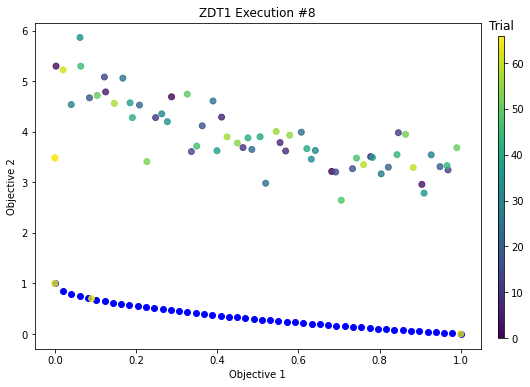

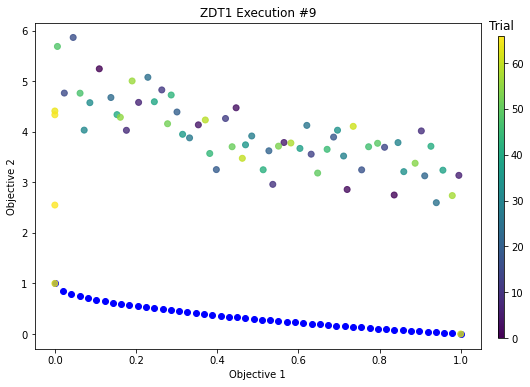

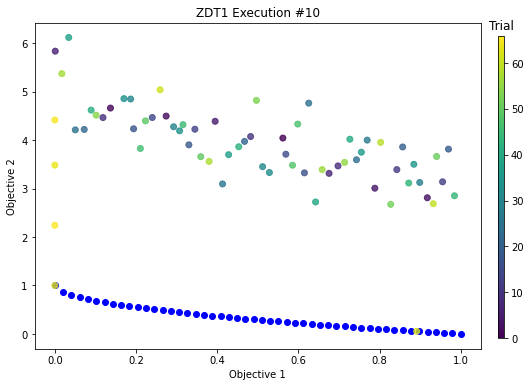

In [ ]:
from torch import Tensor
%matplotlib inline

for exec in range(executions):
  fig, axes = plt.subplots(1, 1, figsize=(8,6))

  pareto_front = Tensor.cpu(problem.gen_pareto_front(50))
  axes.scatter(pareto_front[:, 0], pareto_front[:, 1], color='b')


  cm = plt.cm.get_cmap('viridis')
  batch_number = all_df[exec].trial_index.values
  sc = axes.scatter(all_outcomes[exec][:, 0], all_outcomes[exec][:,1], c=batch_number, alpha=0.8)
  axes.set_title(f'ZDT1 Execution #{exec + 1}')
  axes.set_xlabel("Objective 1")
  axes.set_ylabel("Objective 2")
  norm = plt.Normalize(batch_number.min(), batch_number.max())
  sm =  ScalarMappable(norm=norm, cmap=cm)
  fig.subplots_adjust(right=0.9)
  cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
  cbar = fig.colorbar(sm, cax=cbar_ax)
  cbar.ax.set_title("Trial")

Execution times: [227.37366056 222.46167827 217.57270288 205.76821923 218.87429905
 234.55447578 204.14215612 199.32319021 216.49556708 205.4661727 ]


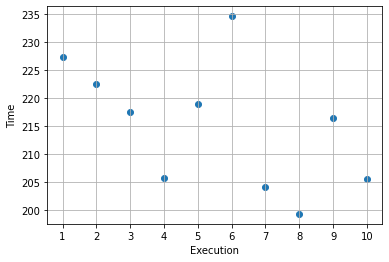

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
plt.xticks(np.arange(1, executions + 1))

axes.scatter(np.arange(1, executions + 1), np.array(execution_times))
axes.grid(True)
axes.set_xlabel("Execution")
axes.set_ylabel("Time")

print("Execution times:", np.array(execution_times))
print("Average execution time:", np.array(execution_times).sum()/len(execution_times))

In [ ]:
print(all_df)

[    trial_index arm_name trial_status generation_method         a         b  \
0             0      0_0      RUNNING             Sobol  0.935757  3.517085   
1             1      1_0      RUNNING             Sobol  0.382330  3.581377   
2             2      2_0      RUNNING             Sobol  0.002369  5.579393   
3             3      3_0      RUNNING             Sobol  0.558451  3.526642   
4             4      4_0      RUNNING             Sobol  0.659964  3.340765   
..          ...      ...          ...               ...       ...       ...   
62           62     62_0      RUNNING  FullyBayesianMOO  1.000000  0.000000   
63           63     63_0      RUNNING  FullyBayesianMOO  0.000000  1.000000   
64           64     64_0      RUNNING  FullyBayesianMOO  0.000000  3.172414   
65           65     65_0      RUNNING  FullyBayesianMOO  0.000000  3.793103   
66           66     66_0      RUNNING  FullyBayesianMOO  0.000000  3.482759   

    is_feasible        x0        x1        x2  ...